# iPython notebook to make a simple (no w-projection) dirty image from OSKAR simulated VLA data.

### Description
Notebook demonstrating making of a simple dirty image from example OSKAR simulated VLA data.

### To run the script you will need:

- ipython (python 2.7)
- numpy (1.9)
- matplotlib
- pyfits (3.3)
- read_oskar_vis.py (python module found in the `oskar_data/scripts` sub-directory)
- Example OSKAR simulated binary data (found in the `oskar_data` sub-directory)

**This notebook is intended to be run from the top level crocodile directory.**

### TODO
- FIX grid correction ...!?

In [1]:
%matplotlib inline
import sys
import os
import numpy
import math
import matplotlib.pyplot as plt
import pyfits
sys.path.append(os.path.join('oskar_data', 'scripts'))
from read_oskar_vis import OskarVis
from parula import parula_map

### 0. Define imaging and gridding parameters

In [2]:
fov = 3.5        # field-of-view, in degrees
imsize = 1024    # Image dimension / grid size, in pixels
support = 3      # GCF support (width = 2 * support + 1)
oversample = 63  # GCF oversample (values per grid cell) - MUST BE ODD

assert oversample % 2 == 1, 'Oversample must be odd valued!'

def fov_to_cell_size(fov, im_size):
    """Evaluate image pixel size (in arcseconds) for a given FoV and number of pixels."""
    r_max = math.sin(math.radians(fov) / 2.0)
    inc = r_max / (0.5 * im_size)
    return math.degrees(math.asin(inc)) * 3600.0

def grid_cell_size(cell_size_lm_arcsec, im_size):
    """Obtain grid cell size from image cell size."""
    return (180. * 3600.) / (im_size * cell_size_lm_arcsec * math.pi)

# Image pixel separation, in arcseconds
cell_size_lm_arcsec = fov_to_cell_size(fov, imsize)
# Grid pixel separation, in wavelengths.
cell_size_uv = grid_cell_size(cell_size_lm_arcsec, imsize)

### 1. Load visibility data.

In [3]:
# Read visibility binary and scale into wavelengths.
vis_file = os.path.join('oskar_data', 'vla_grid_6h', 'test_vla.vis')
oskar_vis = OskarVis(vis_file)
uu, vv, ww = oskar_vis.uvw(flatten=True)
freq_hz = oskar_vis.frequency()
wave_length_m = 299792458.0 / freq_hz
uvw = numpy.array([uu, vv, ww]) / wave_length_m
amp = oskar_vis.stokes_i(flatten=True)

### 2. Generate GCF
- Simple exponential function.
- TODO replace with another function to test grid correction...

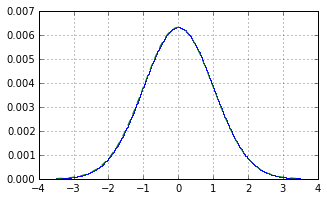

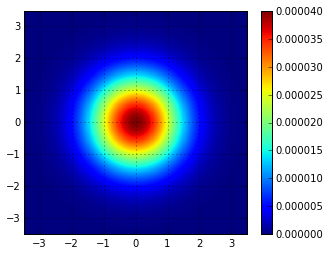

In [4]:
# Generate 1d exponential GCF
sigma = 1.0
gcf_size = (2 * support + 1) * oversample
gcf_u = numpy.arange(0, gcf_size, dtype='f8') - gcf_size / 2
u_inc = 1.0 / oversample
gcf_u *= u_inc
gcf_1d = numpy.exp(-gcf_u**2.0 / (2.0 * sigma**2))
gcf_1d /= numpy.sum(gcf_1d)  # Normalise by area

# Convert to 2-d
gcf_2d = numpy.empty((gcf_size, gcf_size), dtype='f8')
for i in range(0, gcf_size):
    gcf_2d[:, i] = gcf_1d
for j in range(0, gcf_size):
    gcf_2d[j, :] *= gcf_1d

# Plot the GCF
plt.close('gcf 1d')
plt.close('gcf 2d')
fig = plt.figure('gcf 1d', figsize=(5, 3))
ax = fig.add_subplot(111)
ax.step(gcf_u, gcf_1d, where='mid')
ax.plot(gcf_u, gcf_1d, '--')
ax.grid(True)
fig = plt.figure('gcf 2d', figsize=(5, 4))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(gcf_2d, interpolation='nearest', 
               extent=[gcf_u[0], gcf_u[-1], gcf_u[0], gcf_u[-1]])
plt.colorbar(im)
ax.grid(True)

### 3. Gridding! 

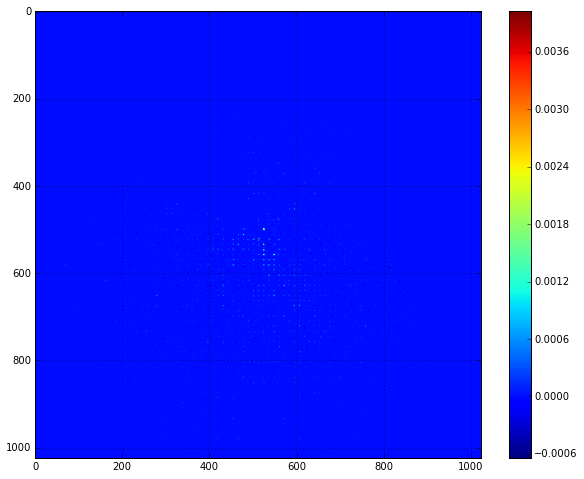

In [5]:
# TODO Reorganise CGF by oversample before entering the loop.

g_centre = imsize / 2
k_centre = gcf_size / 2
kxy = numpy.arange(-support, support + 1) * oversample
kxy_x, kxy_y = numpy.meshgrid(kxy, kxy)
grid = numpy.zeros((imsize, imsize), dtype='c16')
g_sum = 0.0

# Loop over visibility data points.
for i in range(0, amp.shape[0]):
    # uu, vv coordinates scaled to grid space.
    x = -uvw[0, i] / cell_size_uv
    y = uvw[1, i] / cell_size_uv
    
    # Closest grid cell.
    xg = int(round(x))
    yg = int(round(y))
    
    # Grid matrix index
    ix = xg + g_centre
    iy = yg + g_centre
    
    # Check the point is inside the grid.
    if ix + support >= imsize or ix - support < 0:
        continue
    if iy + support >= imsize or iy - support < 0:
        continue
    
    # Scaled distance from nearest grid point
    x_offset = xg - x
    y_offset = yg - y
    
    # gcf offset
    x_delta = x_offset * oversample
    y_delta = y_offset * oversample
    ikx = int(round(x_delta)) + k_centre
    iky = int(round(y_delta)) + k_centre

    # Convolve visibility point onto the grid.
    k = gcf_2d[kxy_y + iky, kxy_x + ikx]
    grid[iy-support:iy+support+1, ix-support:ix+support+1] += k * amp[i] 

    g_sum += numpy.sum(k)

# Normalise grid.
grid /= g_sum    
  
plt.close('grid')
fig = plt.figure('grid', figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(grid.real, interpolation='nearest')
plt.colorbar(im)
ax.grid(True)

### 4. Grid -> image

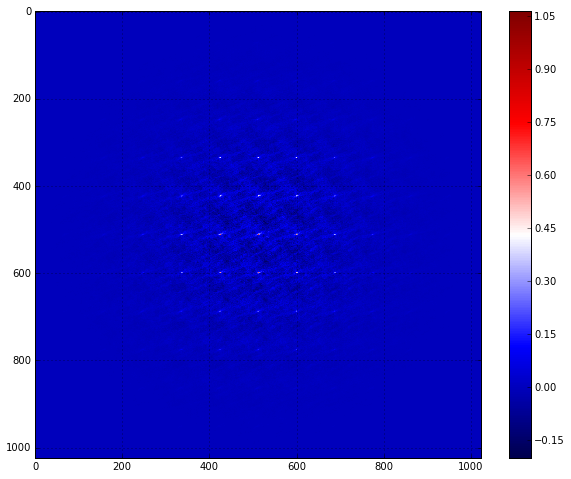

In [6]:
image = numpy.copy(grid)
image[::2, :] *= -1
image[:, ::2] *= -1
image = numpy.fft.fft2(image)
image[::2, :] *= -1
image[:, ::2] *= -1

plt.close('image')
fig = plt.figure('image', figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(image.real, interpolation='nearest', cmap='seismic')
plt.colorbar(im)
ax.grid(True)

### 5. Generate GCF correction (grid correction)
- This currently has a comparison of a few different methods of attempting to do the correction.

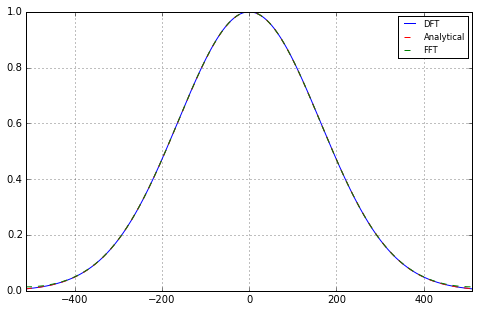

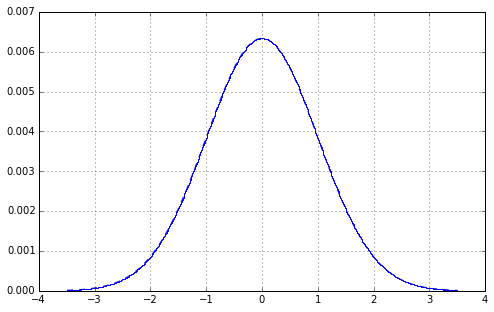

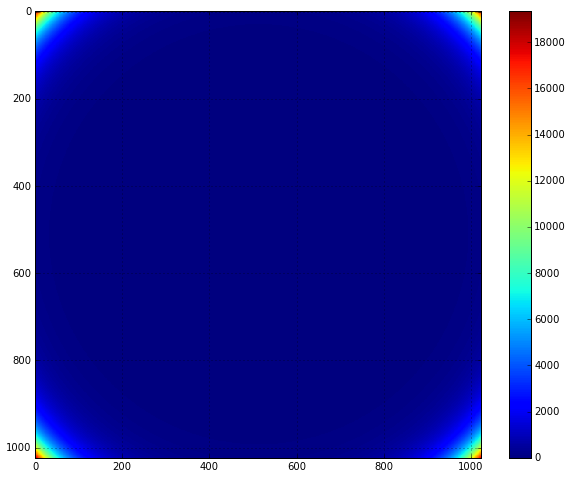

In [7]:
image_theta = numpy.arange(0, imsize, dtype='f8') - imsize / 2.0
image_theta /= imsize / 2.0
image_theta *= math.pi

correction_1d_analytical = numpy.empty(shape=(imsize), dtype='f8')
correction_1d_analytical = numpy.exp(-(sigma**2 * image_theta**2) / 2.0)

correction_1d_dft = numpy.empty(shape=(imsize), dtype='f8')
# xinc = 1.0 / (support * 2 + 1)
# xinc = 1.0 / oversample
for i, l in enumerate(image_theta):
    if l == 0.0:
        correction_1d_dft[i] = 1.0
    else:
        correction_1d_dft[i] = 0.0
        for j, k in enumerate(gcf_1d):
            correction_1d_dft[i] += k * math.cos(gcf_u[j] * l)
#         arg = xinc * l
#         correction_1d_dft[i] *= math.sin(arg) / arg 

correction_1d_fft = numpy.zeros(shape=(imsize), dtype='f8')
gcf_idx = numpy.arange(-support, support + 1) * oversample + (gcf_size / 2)
correction_1d_fft[imsize/2-support:imsize/2+support+1] = gcf_1d[gcf_idx]
correction_1d_fft = numpy.fft.fftshift(numpy.fft.fft(numpy.fft.fftshift(correction_1d_fft)))
correction_1d_fft /= numpy.max(correction_1d_fft) 

plt.close('correction 1d')
fig = plt.figure('correction 1d', figsize=(8, 5))
ax = fig.add_subplot(111)
image_l = numpy.arange(-imsize/2, imsize/2)
#ax.step(image_l, correction_1d_dft, where='mid', c='b')
ax.plot(image_l, correction_1d_dft, 'b-', label='DFT')
#ax.step(image_l, correction_1d_analytical, where='mid', c='r')
ax.plot(image_l, correction_1d_analytical, 'r--', label='Analytical')
#ax.step(image_l, correction_1d_fft.real, where='mid', c='g')
ax.plot(image_l, correction_1d_fft.real, 'g--', label='FFT')
ax.set_xlim(-imsize/2, imsize/2)
plt.legend(fontsize='small')
ax.grid(True)

plt.close('gcf 1d compare')
fig = plt.figure('gcf 1d compare', figsize=(8, 5))
ax = fig.add_subplot(111)
ax.step(gcf_u, gcf_1d, where='mid', c='b')
ax.plot(gcf_u, gcf_1d, 'b--')
ax.grid(True)

# Convert to 2-d
# correction_1d = correction_1d_dft.real
correction_1d = correction_1d_analytical
# correction_1d = correction_1d_fft.real
correction_2d = numpy.empty((imsize, imsize), dtype='f8')
for i in range(0, imsize):
    correction_2d[:, i] = correction_1d
for j in range(0, imsize):
    correction_2d[j, :] *= correction_1d
    
correction_2d = 1. / correction_2d
correction_2d[numpy.abs(correction_2d) > 1.0e5] = numpy.nan
    
plt.close('correction 2d')
fig = plt.figure('correction 2d', figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(correction_2d, interpolation='nearest')
plt.colorbar(im)
ax.grid(True)

### 6. Correct image for GCF and plot corrected image.
- Compare DFT and using analytical form of correction functions

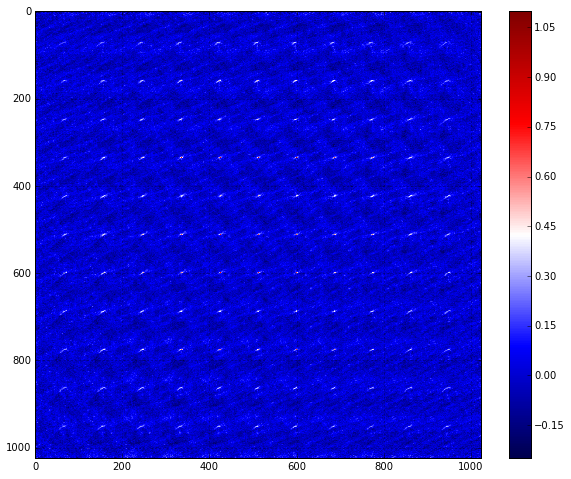

In [8]:
# Convert to 2-d
corrected_image = image.real * correction_2d
    
plt.close('corrected image')
fig = plt.figure('corrected image', figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(corrected_image, interpolation='nearest', cmap='seismic')
plt.colorbar(im)
ax.grid(True)

### 6. Load Reference CASA image

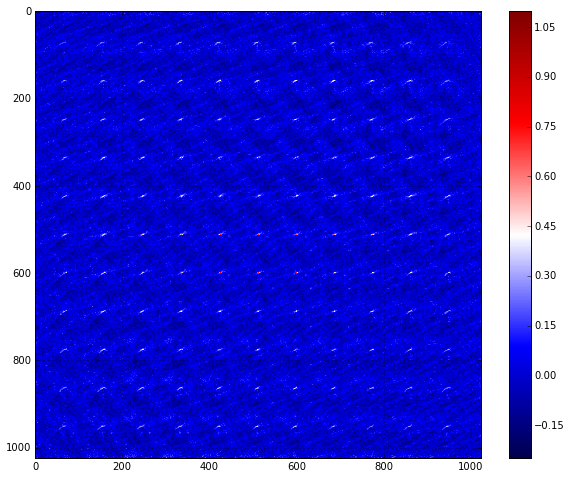

In [9]:
fits_file = os.path.join('oskar_data', 'vla_grid_6h', 
                         'test_vla_dirty_0%04i_w000.fits' % imsize)
casa_image = numpy.squeeze(pyfits.getdata(fits_file))
plt.close('casa image')
fig = plt.figure('casa image', figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(casa_image, interpolation='nearest', cmap='seismic')
plt.colorbar(im)
ax.grid(True)

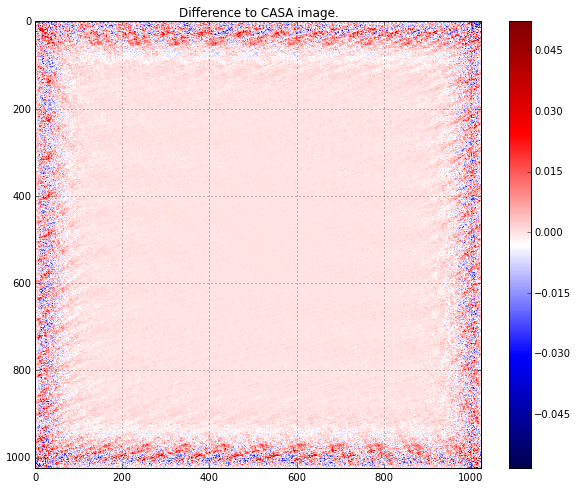

In [10]:
diff = casa_image - corrected_image.real
# diff = casa_image - image.real

plt.close('diff image')
fig = plt.figure('diff image', figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(diff, interpolation='nearest', cmap='seismic')
ax.set_title('Difference to CASA image.')
plt.colorbar(im)
ax.grid(True)

# plt.close('diff slice')
# fig = plt.figure('diff slice', figsize=(8, 8))
# ax = fig.add_subplot(111)
# ax.plot(diff.max(axis=0))
# ax.set_xlim([0, diff.shape[0]])
# ax.grid(True)

